In [5]:
% load_ext autoreload
% autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
root = '/voyager/datasets/CelebA/img_align_celeba/'
attr = '/voyager/datasets/CelebA/list_attr_celeba.txt'

In [8]:
df = pd.read_csv(attr, sep='\s+')

In [9]:
df.shape

(202599, 41)

<AxesSubplot:>

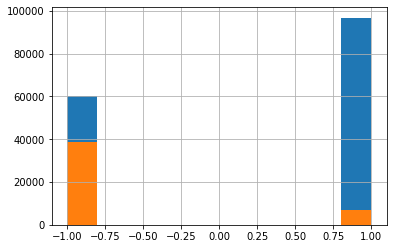

In [10]:
df[df.Young == 1].Attractive.hist()
df[df.Young == -1].Attractive.hist()

In [35]:
from datasets.celeb import CelebDataset, CelebModule

In [36]:
d = CelebDataset(filter_by_label=None, take_all=True, return_pil=False)

In [43]:
from typing import List

import torch
import torchvision

from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze
from ffcv.writer import DatasetWriter

In [33]:
datasets = {
    'train': CelebDataset(train=True, take_positives=True, return_pil=True),  # young train set
    'val': CelebDataset(train=False, take_positives=True, return_pil=True),  # young val set
    'test': CelebDataset(take_positives=False, take_all=True, return_pil=True)  # old test set
}
for (name, ds) in datasets.items():
    writer = DatasetWriter(f'/voyager/datasets/CelebA/{name}.beton', {
        'image': RGBImageField(),
        'label': IntField()
    })
    writer.from_indexed_dataset(ds)


100%|██████████| 148897/148897 [00:19<00:00, 7590.36it/s]

100%|██████████| 7837/7837 [00:02<00:00, 3526.83it/s]

100%|██████████| 45865/45865 [00:05<00:00, 7928.68it/s]


In [55]:
MEAN = [122.5502, 102.1070, 91.2910]
STD = [71.9679, 64.6399, 62.5419]

BATCH_SIZE = 512

loaders = {}
for name in ['train', 'test', 'val']:
    label_pipeline: List[Operation] = [IntDecoder(), ToTensor(), ToDevice('cuda:0'), Squeeze()]
    image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]

    # Add image transforms and normalization
    if name == 'train':
        image_pipeline.extend([
            RandomHorizontalFlip(),
            RandomTranslate(padding=2),
            Cutout(8, tuple(map(int, MEAN))),  # Note Cutout is done before normalization.
        ])
    image_pipeline.extend([
        ToTensor(),
        ToDevice('cuda:0', non_blocking=True),
        ToTorchImage(),
        Convert(torch.float16),
        torchvision.transforms.Normalize(MEAN, STD),
    ])

    # Create loaders
    loaders[name] = Loader(f'/voyager/datasets/CelebA/{name}.beton',
                           batch_size=BATCH_SIZE,
                           num_workers=96 // 2,
                           order=OrderOption.RANDOM,
                           drop_last=(name == 'train'),
                           pipelines={'image': image_pipeline,
                                      'label': label_pipeline})

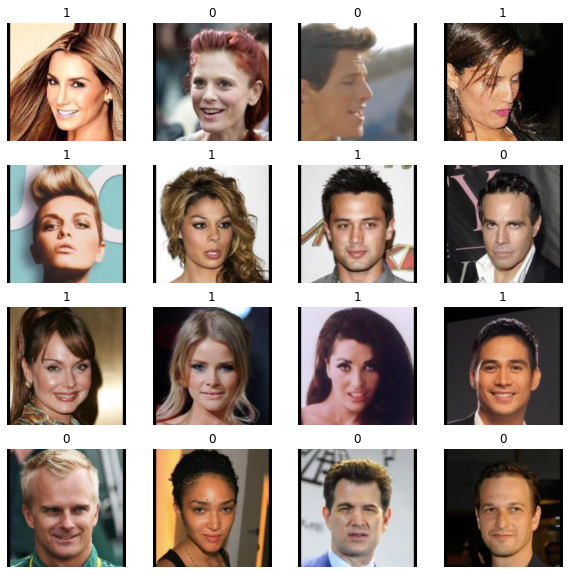

In [37]:
# plot a grid of the first 16 images and their labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img, label = d[i]
    # images to channels last
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

In [68]:
# finetune a resnet 18 model to classify the images
from modelling.image_model import ImageModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

RUN_NAME = 'attractive_young_baseline'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=50,
    deterministic=True,
    callbacks=[EarlyStopping(monitor="val_acc", min_delta=0.00, patience=10, verbose=True, mode='max'),
               ModelCheckpoint(dirpath=f'checkpoints/celeb/baselines/{RUN_NAME}',
                               monitor='val_acc',
                               save_top_k=1,
                               verbose=True,
                               mode='max',
                               ),
               # LearningRateMonitor(),
               ],
    # logger= WandbLogger(project="pqlearning", offline=False, name=RUN_NAME),
    num_sanity_val_steps=0,
    check_val_every_n_epoch=1,
    # log_every_n_steps=1,
)
model = ImageModel(in_channels=3, out_features=2, arch='resnet18', pretrained=False, lr=0.1, optim='SGD',
                   step_size=200, scheduler='cos', weight_decay=5e-4, momentum=0.9, check_negative_labels=False, channels_last=True)
# model = model.to(memory_format=torch.channels_last)

GPU available: True, used: True
GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs


In [75]:
datamodule = CelebModule()

In [69]:
trainer.fit(model, train_dataloaders=loaders['train'], val_dataloaders=loaders['val'])

AttributeError: module 'pytorch_lightning' has no attribute 'LightningModule'

In [65]:
x = loaders['train'].__iter__().__next__()

In [67]:
x[0].shape

torch.Size([512, 3, 224, 224])